# Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. As a part of the student working towards obtaining a Data Analyst Nano-degree program in Udacity, it is important that I get some practice working with the difficulties of these A/B tests. 

The objective of this project is to understand the results of an A/B test run by an e-commerce website. I will work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


#### Find the number of rows in the dataset.

In [3]:
print('There are {}'.format(df.shape[0]), 'number of rows in the dataset')

There are 294478 number of rows in the dataset


#### Give the number of unique users in the dataset.

In [4]:
print('There are {}'.format(df['user_id'].nunique()),'unique users in the dataset')

There are 290584 unique users in the dataset


#### What is the proportion of users converted.

Here we basically calculate the proportion of 1's to 0's (or mean) in the coversion column.

In [5]:
df['converted'].mean()

0.11965919355605512

#### Give the number of times the `new_page` and `treatment` don't match.

There are two ways the new_page and treatment don't match.

1) group = treatment and landing_page = old_page

2) group = control and landing_page = new_page

In [6]:
treatment_group = df['group']=='treatment'
new_landing_page = df['landing_page'] == 'new_page'

#For treatment == new_page == false, that is when treatment don't match new_page
#we will store the result in the dataset treatment_newpage

treatment_newpage = df[(treatment_group== new_landing_page)==False]

In [7]:
#what is the dimension of the treatment_newpage dataframe?

print('The number of times new_page and treatment don\'t match is {}'.format(treatment_newpage.shape[0]))

The number of times new_page and treatment don't match is 3893


#### Do any of the rows have missing values?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [9]:
print('There are no missing values in the rows')

There are no missing values in the rows


#### How should we handle the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**.  

a. Removing these rows is the best thing to do.

Let us now create a new dataset df2 that stores only rows where treatment and new_page meet.

- The new datafame df2 will contain only the treatment group and new landing page. That is where treatment and new_page macth.

- We expect that the size of df2 must be 3893 less than the size of our original dataframe df. This is because 3893 is the numberof times treatment don't match with new page as we already calculated above.

In [10]:
#For treatment == new_page == True, that is when treatment match new_page
#we will store the result in the dataset df2

df2 = df[(treatment_group == new_landing_page) == True]

#check to make sure size of df2 is 3893 less than size df

print('The new datafame has {}'.format(df2.shape[0]),'rows')

The new datafame has 290585 rows


In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

#### How many unique **user_id**s are in **df2**?

In [12]:
print('There are {}'.format(df2['user_id'].nunique()), 'unique users in the new dataset df2')

There are 290584 unique users in the new dataset df2


#### There is one **user_id** repeated in **df2**.  What is it?

In [13]:
#check which user information was duplicated

df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


So information about user with user_id 773192 was repeated.

#### What is the row information for the repeat **user_id**? 

In [14]:
#to get information about the repeated user id

df2.query('user_id==773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [15]:
print('The user_id is 773192, under the treatment group in the new landing page')

The user_id is 773192, under the treatment group in the new landing page


#### Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
df2.drop([1899],inplace=True)


#confirm that the number of rows in df2 is now 1 number short, that is 290854
df2.shape[0] 

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


290584

### Exploring the new dataset df2.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
#We calculate the propotion of 1's to 0's, 
#that is the mean in converted column 

convert_mean = df2['converted'].mean()

print('Regardless of the page received, the probability an individual converting is {}'.format(convert_mean))

Regardless of the page received, the probability an individual converting is 0.11959708724499628


b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
#filter data set to include only control group
control_df = df2.query('group =="control"')['converted']

#probability converted

control_prob = control_df.mean()

print('The probability that an individual in the control group got converted is {}'.format(control_prob))

The probability that an individual in the control group got converted is 0.1203863045004612


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
#filter data set to include only control group
treatment_df = df2.query('group =="treatment"')['converted']

#probability converted

treat_prob = treatment_df.mean()

print('The probability that an individual in the treatment group got converted is {}'.format(treat_prob))

The probability that an individual in the treatment group got converted is 0.11880806551510564


In [20]:
#the observed difference in conversion between the two groups
obs_diff = (treat_prob - control_prob)


print("The observed difference from our statistics is {}".format(obs_diff))


The observed difference from our statistics is -0.0015782389853555567


d. What is the probability that an individual received the new page?

In [21]:
new_p = df2.query('landing_page =="new_page"').count()[0]/df2.shape[0]

print('The probability that an individual received the new page is {}'.format(new_p))


The probability that an individual received the new page is 0.5000619442226688


#### Does the treatment page leads to more conversions?

Considering our results from parts (a) through (d) above, explain below whether we think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

- From the original dataframe, we find that the average conversion rate regardless of the page an individual recieved is $11.96\%$.

- Now if an individual was found in the new page (that is the treatment group), the coversion rate is $11.88 \%$ which is $0.08\%$ less than the overall conversion rate.

- Similarly if an individual was found in the old page (which is aligned with the control group), the conversion rate is $12.04\%$ which is $0.08\%$ greater than the overall conversion rate.

Looking at the conversion rate above, one would say it is not worth putting resources into the new page as the old page has higher conversion rate. However, the difference in conversion rate between the old page and new page could be insignificant (about $0.16\%$), and we could conclude that it could be chance. How do we know this? We could benefit from more testing. A  look at how long the test was run;

In [22]:
#let us look at how long the test was run for

df['timestamp'].min(), df['timestamp'].max()

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

shows that the test was run for 22 days (about 3 weeks), a sufficient amount of time. Hence there is no sufficient evidence that the new treatment page leads to more conversion, and we believe the old page has more conversion at this point until proven not true.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, let us consider we might need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, 

#### What should your null and alternative hypotheses be?  

In terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages, our null and alternative hypothesis are

$$ \begin{aligned}
H_{0}: & \text{ The new page is worse than or as good as the old page}\\
&p_{new} - p_{old} \leq 0 \\
H_{1}: &\text{ The new page is better than the old page}\\
& p_{new} - p_{old} > 0 
\end{aligned}
$$


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


$$ \begin{aligned}
H_{0}: p_{new} - p_{old} = 0 \\
H_{1}: p_{new} - p_{old} \neq 0 
\end{aligned}
$$

So our new hypothesis.

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [23]:
rate_pnew = df2['converted'].mean()
rate_pnew

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [24]:
rate_pold = df2['converted'].mean()
rate_pold

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [25]:
n_new = df2.query('group == "treatment"')['user_id'].count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [26]:
n_old = df2.query('group == "control"')['user_id'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In the simulation below, rate_new is the proportion of users in df2.shape[0] (the population of users from which the sample was drawn) who would convert to new_page. The number of users who would convert to new_page in a simulation of size $n_{new}$ has the binomial distribution with parameters $n_{new}$ and rate_new.

In [27]:
new_page_converted = np.random.binomial(1, rate_pnew, n_new)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted = np.random.binomial(1, rate_pold, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
diffs = new_page_converted.mean() - old_page_converted.mean()
print('Difference in sample population is {}'.format(diffs))

Difference in sample population is 0.001347006377419191


Let us create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process we used in parts (a) through (g) above. 

Store all 10,000 values in a NumPy array called **p_diffs**.

In [30]:
new_converted_simulation = np.random.binomial(n_new, rate_pnew,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, rate_pold,  10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

### Data visualization

Plot a histogram of the **p_diffs**.  

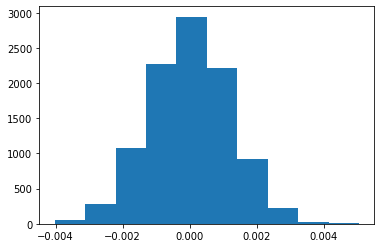

In [31]:
p_diffs = np.array(p_diffs)

plt.hist(p_diffs);

Central limit theory says that with a large enough sample size, our sample mean follows a normal distribution. The plot looks to me like a normal distribution, which is what we expect to see given our large sample size.

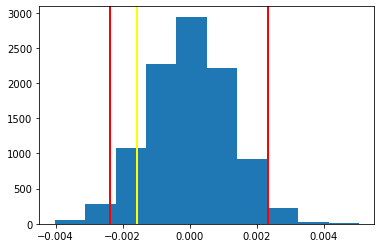

In [32]:
# view 99% confidence interval
low, upper = np.percentile(p_diffs, 2.5), np.percentile(p_diffs, 97.5)
plt.hist(p_diffs);
plt.axvline(x=low, color='red', linewidth=2);
plt.axvline(x=upper, color='red', linewidth=2);
plt.axvline(obs_diff, color='yellow', linewidth=2);


In [33]:
print('Upper bound of the 95% percentile is {}'.format(upper))
print('\nLower bound of the 95% percentile is {}'.format(low))
print('\nObserved difference in our population parameter is {}'.format(obs_diff))


Upper bound of the 95% percentile is 0.0023448030445004007

Lower bound of the 95% percentile is -0.002390296734398408

Observed difference in our population parameter is -0.0015782389853555567


For a significance (alpha) level of $0.05$ (that is a $5\%$ chance of making a Type 1 error), our confidence level is $95\%$. We see from the plot that our null hypothesis value is contained within the confidence interval, suggesting that our null hypothesis did generate our statistics. 

### P-value

#### What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
print("\nProportion of p_diffs greater than observed (p-value): {}".format ((p_diffs > obs_diff).mean()))


Proportion of p_diffs greater than observed (p-value): 0.9049


#### Explanation

What we computed in part j is known as p-value; which is defined as probability that we have falsely rejected the null hypothesis.

What do we expect of this p-value? Since we did not reject the null hypothesis, we expect that the p-value should be high. 

In principle, given that our significance level $\alpha = 0.05$, the following conditions apply
$$ 
\begin{aligned}
p \leq\alpha : & \text{ evidence to reject the null hypothesis}\\
p > \alpha: &\text{ fail to reject the null hypothesis}
\end{aligned}
$$

From our computation, our p = $0.903 > \alpha$ is large, thus there is no evidence against the null hypothesis and we hold on to our belief that 'that the old page has equal conversion rate than the new page'.

### Using computer built-in statistical models

We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the portions we have shown above are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

We have calculated n_new and n_old already, we will calculate the number of conversion for each page.

In [35]:
no_old_convert = df2.query("landing_page == 'old_page'")['converted'].sum()
no_new_convert = df2.query("landing_page == 'new_page'")['converted'].sum()

#### Test statistics and p-value

We will use `stats.proportions_ztest` to compute your test statistic and p-value. 

In [36]:
z_score, p_value = sm.stats.proportions_ztest([no_old_convert, no_new_convert], [n_old, n_new], value=None, alternative='smaller', prop_var=False) 
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

#### What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

#### By definition,

The z-score (which is a measure of standard deviation) is a test of statistical significance that helps us decide whether or not to reject the null hypothesis. 

Now since we used a $95\%$ confidence interval, 

- the critical z-score values are $-1.96$ and $+1.96$ standard deviations and the p-value associated with this confidence level as we have discussed is $0.05$.

- If our z-score lies within the critical z-score values, the p-value will be greater than $0.05$ and you will fail to reject the null hypothesis.


Our computation shows that our z-score is $~1.311$ which is within the z-score critical values, hence we have p-value $~0.905 > 0.05$, hence we fail to reject the null hypothesis that old page and new page has equal conversion rate.  

We see that the p-value obtained from the z-test agrees with the p-value obtained earlier on.

<a id='regression'></a>
### Part III - A regression approach

In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

We note that since each row is either a conversion or no conversion, that is our response variable is a categorical variable with two possible outcomes (conversion or no coversion), we apply the logistic regression to model our regression.

The goal is to use **statsmodels** to fit the logistic regression model to see if there is a significant difference in conversion based on which page a customer receives. To achieve this,

- we will create in df2 a column for the intercept, 

- we will also create a dummy variable column for which page each user received: **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
#adding an intercept column
df2['intercept'] = 1

#creating our dummy variables
df2[['new_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2.head()


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,1,0


In [38]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

We will use **statsmodels** to instantiate our regression model on the intercept and ab_page columns we created above. 

In [39]:
#fitting our logistic regression model

logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Here we provide the summary of our model 

In [40]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 20 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        09:17:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

#### Discussion
Here there is an inverse relationship between conversion and group of a customer. In other words, the probability of conversion is higher for customers in the control group (our baseline) as compared to treatment group.

#### Odd ratio:
So, np.exp($\beta_{0}$) = 1/exp(−1.9888) = 7.31 is the chance of conversion among those customers that are in the control group holding all variables constant.

likewise we expect the probability of a customer in the treatment group converting to decrease by (1/np.exp(-0.0150) = 1.015 ), all variables kept constant.

#### Why does the p-value associated with  **ab_page** differ from the value found in **Part II**? What are the null and alternative hypotheses associated with our regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

#### answer

The explanatory variable in this model is group, which we have coded using an indicator variable with values ab_page = 1 for treatment group and control 0 for control group. The response variable, conversion, is also an indicator variable. Thus, each customer either converts to new page or does not convert to new page. The model says that the probability, p, that a customer would convert depends upon the customer's group (ab_page = 1 or control = 0). So there are two possible values for p—say, p_new and p_old.

- The p-value associated with intercept is $0.00$ which is less than $0.05$ the significance ($\alpha$) value, hence it is statistically significant in predicting whether the customer converts or not. Likewise the p-value associated with ab_page is $0.19$ and since it is larger than the significance ($\alpha$) level of  $0.05$, shows us that the landing page is not statistically significant in predicting whether the customer converts or not. Here the null and alternative hypothesis for the slope $\beta_1$ or intercep $\beta_{0}$ for the regression are respectively:
$$
\begin{aligned}
H_{0}: \beta_{i} = 0\\
H_{1}: \beta_{i} \neq 0 
\end{aligned}
$$
which strictly attempts to predicts a differece in the two values, 

- When we look at the p-value found in Part II, we see a huge difference. This is because the null and alternative hypotheses there were respectively

$$
\begin{aligned}
H_{0}: \leq 0\\
H_{1}: > 0 
\end{aligned}
$$
which aims to predict which page gets more conversions.



#### Are there other things that might influence whether or not an individual converts? Is it appropraiate to add these variables to our model? What possible setbacks might we encounter?

Variable like countries where an individual lives in might influence conversion rate.
When we consider multiple explanatroy variables for our regression model, we are more likely to draw a better conlusion based on our observations. So far, it does not appear that we have a siginifcant evidence whether a user in the treatment or control group converts or not. Therefore, it is probably a good idea to see whether other factors might predict conversion. 

We would have to ensure that the additional terms are

1) correlated with the response variable (a linear relationship)

2) not correlated or similar to each other.

Also we would have to transform any non-linear features.


### Introducing another explanatory variable (country where users live in)

Now along with testing if the conversion rate changes for different pages, lets us also add an effect based on which country a user lives in. 

A dataset **countries.csv'** with a list of countries are provided. We will read this dataset and merge the result with our df2 dataset. 

#### Does it appear that country had an impact on conversion?  

In [42]:
countries_df = pd.read_csv('./countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [43]:
df3 = countries_df.set_index('user_id').join(df2.set_index('user_id'
), how='inner')
df3.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,control,ab_page
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1


In [44]:
# review country column data, how many unique entries are there?
df3['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [45]:
# Create the necessary dummy variables

df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])
df3.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,control,ab_page,CA,UK,US
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0,1,0


In [46]:
logit_mod = sm.Logit(df3['converted'], df3[['intercept', 'CA', 'UK']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 20 Jul 2020   Pseudo R-squ.:               1.521e-05
Time:                        09:18:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

With p-values that are greater than the signifcance ($\alpha$) level of 0.05, it does not appear that country has a significant impact on conversion.

However, customers who live in Canada (CA) are (1/np.exp(-0.048)) = 1.04 times less likely to convert compared to customers who live in the United States (US), while customers who live in the United Kingdom are np.exp(0.0099) = 1.01 more likely to convert than customers living in the US.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [47]:
logit_mod3 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'UK']])
results = logit_mod3.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 20 Jul 2020   Pseudo R-squ.:               2.323e-05
Time:                        09:18:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

With p-values that are greater than the signifcance ($\alpha$) level of 0.05, it does not appear that interaction between country and landing page has a significant impact on conversion rate.

Since there is no linear relationship here, one last thing we could consider to be sure of our conclusion is adding higher order terms to our list of independent variables.

In [48]:
df3['UK_new_page'] = df3['UK']*df3['ab_page']
df3['US_new_page'] = df3['US']*df3['ab_page']
df3['CA_new_page'] = df3['CA']*df3['ab_page']
df3.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,control,ab_page,CA,UK,US,UK_new_page,US_new_page,CA_new_page
user_id,,,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0,1,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0,1,0,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0,1,0,1,0,0


In [49]:
# taking US as baseline

logit_mod = sm.Logit(df3['converted'], df3[['intercept', 'CA_new_page', 'UK_new_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 20 Jul 2020   Pseudo R-squ.:               2.364e-05
Time:                        09:18:24   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.08085
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.9963      0.006   -322.049      0.000      -2.008      -1.984
CA_new_page    -0.0752      0.038     -1.997      0.046      -0.149      -0.001
UK_new_page     0.0149      0.017      0.862      0.389      -0.019       0.049
===============================================================================
"""

In [50]:
1/np.exp(-0.0752), np.exp(0.0149)

(1.0780997492739288, 1.0150115583846535)

We see that for Canada (CA), the p-value has improved to be almost statistically significant for predicting our response. This shows that adding higher terms could help us predict our response rightly. 

Overall the difference we observe are quite insignificant: Here we notice that users living in CA are 1.078 times less likely to convert to a new page compared to users living in the US. Similarly, users in the UK are 1.015 times more likely to convert than users in US. This tells us that users in Canada have change aversion and users in the UK are more drwan to change. 


In [51]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0